# Fase 3: Ground Truth Generation

Questo notebook genera il ground truth utilizzando i VIN comuni tra le due sorgenti.

## Obiettivi
1. Caricare i dataset allineati
2. Identificare coppie di record con VIN identici (match)
3. Generare coppie di non-match
4. Creare split train/validation/test
5. Salvare in `data/ground_truth/`

## Statistiche Attese
- Match: Coppie di record con stesso VIN
- Non-match: Coppie di record con VIN diversi
- Ratio: Tipicamente 1:1 o 1:2 (match:non-match)
- Split: 70% train, 10% validation, 20% test

## 1. Import Librerie

In [22]:
import sys
import os

# Aggiungi il percorso della cartella src al PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
sys.path.append(os.path.abspath('..'))

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import moduli personalizzati
from src.ground_truth import GroundTruthGenerator

# Imposta stile grafici
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerie importate con successo!")

✓ Librerie importate con successo!


## 2. Caricamento Dataset Allineati

In [24]:
# Percorsi dei dataset allineati
craigslist_path = '../data/processed/craigslist_aligned.csv'
usedcars_path = '../data/processed/usedcars_aligned.csv'

# Carica i dataset
print("Caricamento dataset allineati...")
df_craigslist = pd.read_csv(craigslist_path, low_memory=False)
print(f"✓ Craigslist: {len(df_craigslist):,} righe, {len(df_craigslist.columns)} colonne")

df_usedcars = pd.read_csv(usedcars_path, low_memory=False)
print(f"✓ US Used Cars: {len(df_usedcars):,} righe, {len(df_usedcars.columns)} colonne")

print(f"\nColonne comuni: {set(df_craigslist.columns) & set(df_usedcars.columns)}")

Caricamento dataset allineati...
✓ Craigslist: 426,880 righe, 17 colonne
✓ US Used Cars: 3,000,040 righe, 14 colonne

Colonne comuni: {'vin', 'manufacturer', 'drive', 'description', 'odometer', 'year', 'source', 'model', 'transmission', 'fuel', 'paint_color', 'type', 'price', 'cylinders'}


## 3. Analisi VIN

In [25]:
# Statistiche VIN
print("STATISTICHE VIN:")
print("=" * 80)
print(f"\nCraigslist:")
print(f"  - Totale record: {len(df_craigslist):,}")
print(f"  - VIN non nulli: {df_craigslist['vin'].notna().sum():,}")
print(f"  - VIN validi (>=11 caratteri): {(df_craigslist['vin'].str.len() >= 11).sum():,}")
print(f"  - VIN unici: {df_craigslist['vin'].nunique():,}")

print(f"\nUS Used Cars:")
print(f"  - Totale record: {len(df_usedcars):,}")
print(f"  - VIN non nulli: {df_usedcars['vin'].notna().sum():,}")
print(f"  - VIN validi (>=11 caratteri): {(df_usedcars['vin'].str.len() >= 11).sum():,}")
print(f"  - VIN unici: {df_usedcars['vin'].nunique():,}")

STATISTICHE VIN:

Craigslist:
  - Totale record: 426,880
  - VIN non nulli: 265,527
  - VIN validi (>=11 caratteri): 265,350
  - VIN unici: 118,017

US Used Cars:
  - Totale record: 3,000,040
  - VIN non nulli: 2,999,035
  - VIN validi (>=11 caratteri): 2,998,734
  - VIN unici: 2,998,995


In [26]:
# Trova VIN comuni
vins_craigslist = set(df_craigslist[df_craigslist['vin'].notna()]['vin'])
vins_usedcars = set(df_usedcars[df_usedcars['vin'].notna()]['vin'])

common_vins = vins_craigslist & vins_usedcars

print(f"\nVIN COMUNI TRA LE DUE SORGENTI:")
print("=" * 80)
print(f"VIN in Craigslist: {len(vins_craigslist):,}")
print(f"VIN in US Used Cars: {len(vins_usedcars):,}")
print(f"VIN comuni: {len(common_vins):,}")
print(f"\nPotenziali match da VIN comuni: {len(common_vins):,}")


VIN COMUNI TRA LE DUE SORGENTI:
VIN in Craigslist: 118,017
VIN in US Used Cars: 2,998,995
VIN comuni: 3,958

Potenziali match da VIN comuni: 3,958


## 4. Generazione Ground Truth

In [27]:
# Crea generatore di ground truth
print("Creazione generatore ground truth...")
gt_generator = GroundTruthGenerator(
    df1=df_craigslist,
    df2=df_usedcars,
    vin_column='vin',
    min_vin_length=11
)
print("✓ Generatore creato")

Creazione generatore ground truth...
✓ Generatore creato


In [28]:
# Trova match basati su VIN
print("\nRicerca match basati su VIN...")
matches = gt_generator.find_matches()

print(f"\n✓ Match trovati: {len(matches):,}")
print("\nCampione di match:")
display(matches.head(10))


Ricerca match basati su VIN...
Pulizia VIN in corso...
DF1: 426880 -> 117893 record con VIN validi
DF2: 3000040 -> 2998694 record con VIN validi
VIN comuni trovati: 3955
Coppie di match generate: 3955

✓ Match trovati: 3,955

Campione di match:


,record_id_1,record_id_2,vin,label
0,df1_337459,df2_605758,2CTFLREC5B6469026,1
1,df1_261608,df2_2551827,3N1CN8DV7LL905283,1
2,df1_65805,df2_2667860,KM8J3CA49GU109280,1
3,df1_376168,df2_2510436,KMHGN4JE3FU068257,1
4,df1_195662,df2_919356,1FM5K8D87DGA15182,1
5,df1_9990,df2_2412102,JM1BL1W6XB1403921,1
6,df1_160170,df2_1325043,4T1BK3DB7AU356595,1
7,df1_73021,df2_2266313,1FMCU9J9XFUC14834,1
8,df1_288696,df2_585804,5FNRL38699B014311,1
9,df1_394704,df2_829636,1LNHL9DR6AG609301,1


In [29]:
# Genera non-match
print("\nGenerazione non-match...")
non_matches = gt_generator.generate_non_matches(
    ratio=1.0  # Stesso numero di match (ratio 1:1)
)

print(f"\n✓ Non-match generati: {len(non_matches):,}")
print("\nCampione di non-match:")
display(non_matches.head(10))


Generazione non-match...
Pulizia VIN in corso...
DF1: 426880 -> 117893 record con VIN validi
DF2: 3000040 -> 2998694 record con VIN validi
Generazione di 3955 non-match...
Non-match generati: 3955

✓ Non-match generati: 3,955

Campione di non-match:


,record_id_1,record_id_2,vin_1,vin_2,label
0,df1_170446,df2_2797745,1FTZR45E18PA12282,3GNKBFRSXKS643159,0
1,df1_377285,df2_2383246,2HKRM3H78EH541841,1FMJU1KT0HEA19874,0
2,df1_180501,df2_2835554,3VWDB7AJ4HM314364,2CNDL63F566166750,0
3,df1_73023,df2_770227,2U87PN100693,KNALC4J11H5060769,0
4,df1_147512,df2_784065,3FA6P0D95ER289971,5TDHZRBH9LS050459,0
5,df1_89076,df2_2907850,WDDHF8HB7AA121177,WAUB8GFF4H1052370,0
6,df1_23962,df2_2599435,1GNEK13T62J283567,1HGCP36848A000145,0
7,df1_289386,df2_1737088,2G1WC5EM2A1153181,WA1LAAF74KD019807,0
8,df1_45441,df2_2380697,3CZRU5H79JM722621,2C4RDGCG1KR692338,0
9,df1_329629,df2_1171635,WDDGF8BB0BR159907,1FM5K7D84DGA91467,0


## 5. Creazione Dataset Ground Truth Completo

In [30]:
# Crea ground truth completo
ground_truth = gt_generator.create_ground_truth()

print("GROUND TRUTH COMPLETO:")
print("=" * 80)
print(f"Totale coppie: {len(ground_truth):,}")
print("\nDistribuzione label:")
print(ground_truth['label'].value_counts())
print(f"\nPercentuale match: {(ground_truth['label'].sum() / len(ground_truth) * 100):.2f}%")

print("\nCampione ground truth:")
display(ground_truth.head(10))

Ground truth totale: 7910 coppie
  - Match: 3955
  - Non-match: 3955
GROUND TRUTH COMPLETO:
Totale coppie: 7,910

Distribuzione label:
label
1    3955
0    3955
Name: count, dtype: int64

Percentuale match: 50.00%

Campione ground truth:


,record_id_1,record_id_2,vin,label,vin_1,vin_2,price_1,price_2,year_1,year_2,...,size_1,size_2,type_1,type_2,paint_color_1,paint_color_2,state_1,state_2,description_1,description_2
0,df1_359435,df2_1612222,2C4RC1BG9GR164488,1,NaN,NaN,15700.0,13918.0,2016.0,2016,...,NaN,None,NaN,Minivan,NaN,True Blue Pearlcoat,tn,None,🚗 2016 CHRYSLER TOWN & COUNTRY TOURING CLEAN T...,Odometer is 2319 miles below market average! ...
1,df1_1221,df2_1934320,NaN,0,3C63RRHL0LG260671,2FTRX18L71CA22871,64900.0,2499.0,NaN,2001,...,NaN,None,pickup,Pickup Truck,white,Arizona Beige Clearcoat Metallic,al,None,2020 *Ram* *3500* RAM 3500 DUALLY 4X4 CUMMINS ...,2001 Ford F-150 V84WD HI/LOCD PlayerCruisePow...
2,df1_115787,df2_1943008,NaN,0,1G2ZM577294115754,1FTEW1EP8JFE68590,5500.0,36999.0,2009.0,2018,...,NaN,None,NaN,Pickup Truck,NaN,Shadow Black,fl,None,Do you need a sporty sedan? Come see our local...,"XLT trim. CARFAX 1-Owner, GREAT MILES 9,589! F..."
3,df1_368770,df2_2421467,3GCUKSEC6JG376211,1,NaN,NaN,38990.0,35490.0,2018.0,2018,...,NaN,None,pickup,Pickup Truck,NaN,Summit White,tx,None,2018 *** Chevrolet Silverado 1500 LTZ Pickup *...,Welcome to Lakeside Motors. Every car has been...
4,df1_11614,df2_2346024,W1N0G8DB0LF841610,1,NaN,NaN,641.0,45615.0,2020.0,2020,...,NaN,None,SUV,SUV / Crossover,NaN,Black,az,None,"2020 Mercedes-Benz GLC 300 FOR ONLY $641/mo!7,...",Contact Mercedes Benz Of Arrowhead today for i...
5,df1_376763,df2_754810,NaN,0,JM3TCACY9J0201027,1FM5K8D84EGA20051,NaN,15990.0,2018.0,2014,...,NaN,None,SUV,SUV / Crossover,blue,Black,tx,None,🔵`Se Habla Español` ☎️📲 Call or Text Now...,Recent Arrival! Odometer is 17859 miles below ...
6,df1_28844,df2_2625315,5UXKR2C56J0X08206,1,NaN,NaN,NaN,38988.0,2018.0,2018,...,NaN,None,SUV,SUV / Crossover,NaN,Space Gray Metallic,ca,None,Future Ford of Sacramento STOCK #: P16...,Priced below KBB Fair Purchase Price! Navigati...
7,df1_316763,df2_2474050,NaN,0,3GTP9CEK5MG270584,1GCPKPE79CF218303,837.0,13931.0,2021.0,2012,...,NaN,None,NaN,Pickup Truck,blue,Summit White,or,None,2021 GMC Sierra 1500 ELEVATION Brads Chevy -...,[!@@ NL @@!]- Trailering Package; Heavy-Duty[!...
8,df1_31070,df2_2839840,1FTEW1CG4GKE05649,1,NaN,NaN,NaN,28295.0,2016.0,2016,...,NaN,None,NaN,Pickup Truck,NaN,Ingot Silver Metallic,ca,None,2016 Ford F- WD SUPERCREW XLT * Great Deals ...,Our great looking 2016 Ford F-150 XLT SuperCre...
9,df1_312396,df2_2790868,WD3PE7CD3HP525736,1,NaN,NaN,38990.0,31995.0,2017.0,2017,...,NaN,None,van,Van,white,Arctic White,or,None,2017 Mercedes-Benz Sprinter 2500 Cargo Van 3.0...,CLEAN CARFAX ONE OWNER **DRIVING ASSISTANCE PA...


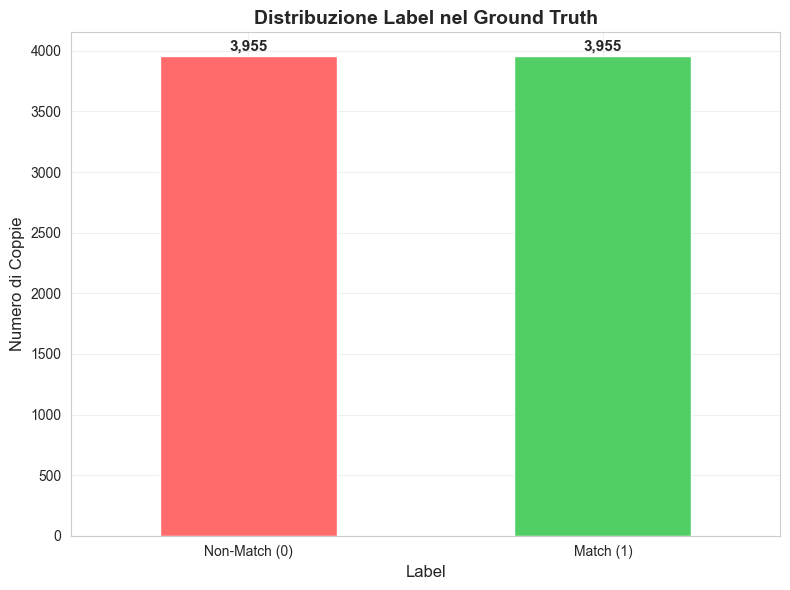

In [31]:
# Visualizza distribuzione label
fig, ax = plt.subplots(figsize=(8, 6))
ground_truth['label'].value_counts().plot(kind='bar', ax=ax, color=['#ff6b6b', '#51cf66'])
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Numero di Coppie', fontsize=12)
ax.set_title('Distribuzione Label nel Ground Truth', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Non-Match (0)', 'Match (1)'], rotation=0)
ax.grid(True, alpha=0.3)

# Aggiungi valori sulle barre
for i, v in enumerate(ground_truth['label'].value_counts().values):
    ax.text(i, v + 50, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/visualizations/ground_truth_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Split Train/Validation/Test

In [32]:
# Split del ground truth
print("Creazione split train/validation/test...")

train, validation, test = gt_generator.split_ground_truth(
    ground_truth=ground_truth,
    test_size=0.2,
    val_size=0.1,
    random_state=42
)

print("\nSTATISTICHE SPLIT:")
print("=" * 80)
print(f"Training set:   {len(train):,} coppie ({len(train)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {train['label'].sum():,}")
print(f"  - Non-match:  {len(train) - train['label'].sum():,}")

print(f"\nValidation set: {len(validation):,} coppie ({len(validation)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {validation['label'].sum():,}")
print(f"  - Non-match:  {len(validation) - validation['label'].sum():,}")

print(f"\nTest set:       {len(test):,} coppie ({len(test)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {test['label'].sum():,}")
print(f"  - Non-match:  {len(test) - test['label'].sum():,}")

Creazione split train/validation/test...
Split completato:
  - Training: 5537 (70.0%)
  - Validation: 791 (10.0%)
  - Test: 1582 (20.0%)

STATISTICHE SPLIT:
Training set:   5,537 coppie (70.0%)
  - Match:      2,769
  - Non-match:  2,768

Validation set: 791 coppie (10.0%)
  - Match:      395
  - Non-match:  396

Test set:       1,582 coppie (20.0%)
  - Match:      791
  - Non-match:  791


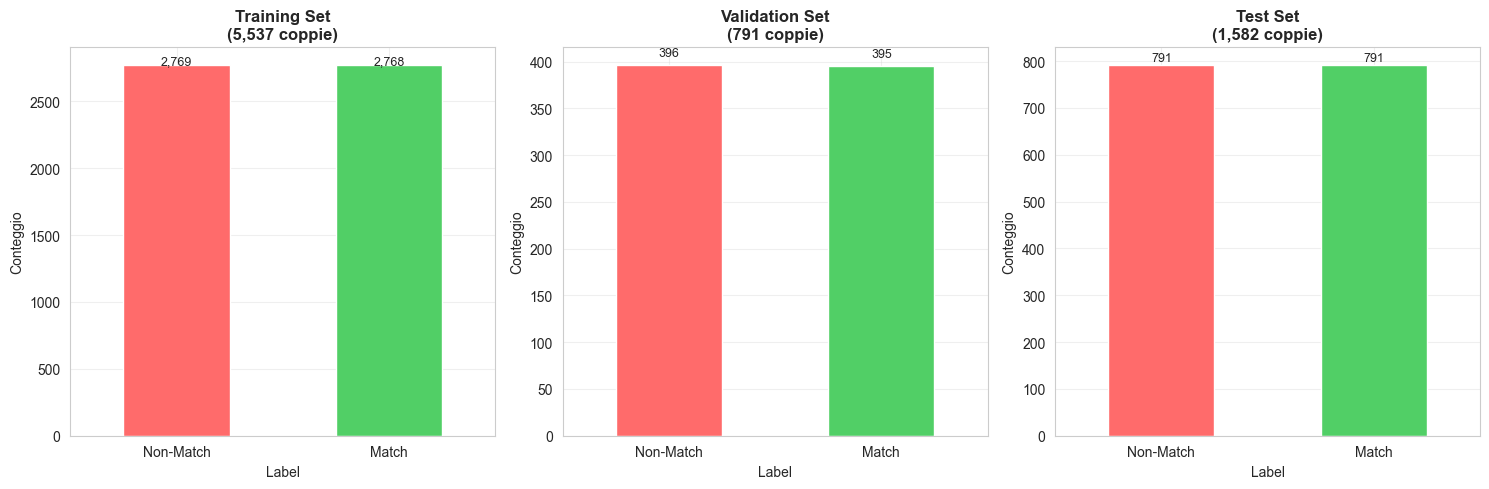

In [33]:
# Visualizza distribuzione split
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (data, name) in enumerate([(train, 'Training'), (validation, 'Validation'), (test, 'Test')]):
    data['label'].value_counts().plot(kind='bar', ax=axes[idx], color=['#ff6b6b', '#51cf66'])
    axes[idx].set_title(f'{name} Set\n({len(data):,} coppie)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Label', fontsize=10)
    axes[idx].set_ylabel('Conteggio', fontsize=10)
    axes[idx].set_xticklabels(['Non-Match', 'Match'], rotation=0)
    axes[idx].grid(True, alpha=0.3)
    
    # Aggiungi valori
    for i, v in enumerate(data['label'].value_counts().values):
        axes[idx].text(i, v + 10, f'{v:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/visualizations/ground_truth_splits.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Salvataggio Ground Truth

In [34]:
# Crea directory se non esiste
os.makedirs('../data/ground_truth', exist_ok=True)

# Salva i file
print("Salvataggio ground truth...")

train.to_csv('../data/ground_truth/train.csv', index=False)
print(f"✓ Training salvato: data/ground_truth/train.csv ({len(train):,} coppie)")

validation.to_csv('../data/ground_truth/validation.csv', index=False)
print(f"✓ Validation salvato: data/ground_truth/validation.csv ({len(validation):,} coppie)")

test.to_csv('../data/ground_truth/test.csv', index=False)
print(f"✓ Test salvato: data/ground_truth/test.csv ({len(test):,} coppie)")

ground_truth.to_csv('../data/ground_truth/ground_truth_full.csv', index=False)
print(f"✓ Ground truth completo salvato: data/ground_truth/ground_truth_full.csv ({len(ground_truth):,} coppie)")

print("Fase 3 completata con successo!")

Salvataggio ground truth...
✓ Training salvato: data/ground_truth/train.csv (5,537 coppie)
✓ Validation salvato: data/ground_truth/validation.csv (791 coppie)
✓ Test salvato: data/ground_truth/test.csv (1,582 coppie)
✓ Ground truth completo salvato: data/ground_truth/ground_truth_full.csv (7,910 coppie)
Fase 3 completata con successo!


## 8. Verifica Qualità Ground Truth

In [35]:
# Carica un campione di match e verifica manualmente
print("VERIFICA QUALITÀ GROUND TRUTH:")
print("=" * 80)

# Prendi 5 match casuali
sample_matches = train[train['label'] == 1].sample(5, random_state=42)

for idx, row in sample_matches.iterrows():
    rec1_id = row['record_id_1']
    rec2_id = row['record_id_2']
    
    # Trova i record originali
    rec1 = gt_generator.df1[gt_generator.df1['record_id'] == rec1_id].iloc[0]
    rec2 = gt_generator.df2[gt_generator.df2['record_id'] == rec2_id].iloc[0]
    
    print(f"\n{'='*80}")
    print(f"MATCH #{idx+1} - VIN: {row['vin']}")
    print(f"{'-'*80}")
    print("Craigslist:")
    print(f"  Year: {rec1.get('year')} | Make: {rec1.get('manufacturer')} | Model: {rec1.get('model')}")
    print(f"  Price: ${rec1.get('price'):,.0f} | Odometer: {rec1.get('odometer'):,.0f}")
    print("\nUS Used Cars:")
    print(f"  Year: {rec2.get('year')} | Make: {rec2.get('manufacturer')} | Model: {rec2.get('model')}")
    print(f"  Price: ${rec2.get('price'):,.0f} | Odometer: {rec2.get('odometer'):,.0f}")

VERIFICA QUALITÀ GROUND TRUTH:

MATCH #1938 - VIN: 3FA6P0AU5KR100210
--------------------------------------------------------------------------------
Craigslist:
  Year: 2019.0 | Make: ford | Model: fusion
  Price: $17,800 | Odometer: 29,631

US Used Cars:
  Year: 2019 | Make: ford | Model: Fusion Hybrid
  Price: $19,999 | Odometer: 29,222

MATCH #2519 - VIN: 5N1AA0NC7FN607024
--------------------------------------------------------------------------------
Craigslist:
  Year: 2015.0 | Make: nissan | Model: armada
  Price: $19,995 | Odometer: 42,706

US Used Cars:
  Year: 2015 | Make: nissan | Model: Armada
  Price: $19,995 | Odometer: 42,706

MATCH #4002 - VIN: 5N1DL0MN0KL567904
--------------------------------------------------------------------------------
Craigslist:
  Year: 2019.0 | Make: infiniti | Model: qx60 pure
  Price: $24,255 | Odometer: 41,628

US Used Cars:
  Year: 2019 | Make: infiniti | Model: QX60
  Price: $28,995 | Odometer: 41,628

MATCH #3011 - VIN: 2C4RDGCG6ER122694

## 9. Riepilogo e Statistiche Finali

In [36]:
# Crea report riepilogativo
report = f"""
{'='*80}
REPORT GROUND TRUTH GENERATION
{'='*80}

DATASET SORGENTE:
  - Craigslist:    {len(df_craigslist):,} record
  - US Used Cars:  {len(df_usedcars):,} record

VIN ANALYSIS:
  - VIN comuni:    {len(common_vins):,}
  - Match generati: {len(matches):,}
  - Non-match generati: {len(non_matches):,}

GROUND TRUTH:
  - Totale coppie: {len(ground_truth):,}
  - Match:         {ground_truth['label'].sum():,} ({ground_truth['label'].sum()/len(ground_truth)*100:.1f}%)
  - Non-match:     {len(ground_truth) - ground_truth['label'].sum():,} ({(len(ground_truth) - ground_truth['label'].sum())/len(ground_truth)*100:.1f}%)

SPLIT:
  - Training:      {len(train):,} coppie ({len(train)/len(ground_truth)*100:.1f}%)
  - Validation:    {len(validation):,} coppie ({len(validation)/len(ground_truth)*100:.1f}%)
  - Test:          {len(test):,} coppie ({len(test)/len(ground_truth)*100:.1f}%)

FILE GENERATI:
  ✓ data/ground_truth/train.csv
  ✓ data/ground_truth/validation.csv
  ✓ data/ground_truth/test.csv
  ✓ data/ground_truth/ground_truth_full.csv

{'='*80}
"""

print(report)

# Salva report
with open('../results/ground_truth_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)
print("✓ Report salvato in: results/ground_truth_report.txt")


REPORT GROUND TRUTH GENERATION

DATASET SORGENTE:
  - Craigslist:    426,880 record
  - US Used Cars:  3,000,040 record

VIN ANALYSIS:
  - VIN comuni:    3,958
  - Match generati: 3,955
  - Non-match generati: 3,955

GROUND TRUTH:
  - Totale coppie: 7,910
  - Match:         3,955 (50.0%)
  - Non-match:     3,955 (50.0%)

SPLIT:
  - Training:      5,537 coppie (70.0%)
  - Validation:    791 coppie (10.0%)
  - Test:          1,582 coppie (20.0%)

FILE GENERATI:
  ✓ data/ground_truth/train.csv
  ✓ data/ground_truth/validation.csv
  ✓ data/ground_truth/test.csv
  ✓ data/ground_truth/ground_truth_full.csv


✓ Report salvato in: results/ground_truth_report.txt
